# FATES parameter ensemble evaluation 

This code evaluates the performance of 287 parameter ensemble member simulations against observations at a tropical forest test site, Barro Colorado Island, Panama. Parameter ensemble member simulations are identical (same model structure, initial conditions, and meteorological forcing) except that they differ in 12 plant trait parameters. Values for these plant trait parameters were sampled from observationally constrained distributions when possible.


## Step 1: Load libraries

In [1]:
import netCDF4 as nc4
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import stats

## Step 2: Load and preprocess data

Here we load the data and calculate time series of annual mean values for six ecosystem characteristics for all the simulations and observations. This code section returns two multidimensional arrays, one for model output and one for observations, that contain annual mean values for each variable organized by parameter set and background carbon dioxide concentration.

The six ecosystem characteristics included in these arrays are:

- Leaf area index,
- Above-ground biomass,
- Basal area,
- Gross primary productivity,
- Latent heat flux, and
- Sensible heat flux.

### 2.1  Model output

This part of the code loads the model output for all FATES simulations in our parameter ensemble. Then it calculates time series of annual mean values for the six variables we use to evaluate the performance of each parameter set.

In [2]:
def annmeants(filepath,var,varfiletype,nyrs,conv_factor):
    ''' Calculate time series of annual means for a model output variable.
    :param filepath (str): file path to data file
    :param var (str): name of variable to call from filename
    :param nyrs (int, float): number of years to analyze
    :param conv_factor (float): conversion factor specific to variable specified by var
    :return: 2-D array containing annual mean time series (ensemble member, nyrs)
    '''
    
    # If model output is stored as monthly average for all tree sizes,
    # need to calculate annual mean.   
    if varfiletype == 0:
        
        # Load monthly time series
        # For all cases except latent heat flux (FLH):
        if var != 'FLH':
            mthts_temp = nc4.Dataset(filepath).variables[var][:,:,0]
        
        # For the special case of latent heat flux:
        elif var == 'FLH':
            # Sum of three terms:
            mthts_temp = (nc4.Dataset(filepath).variables['FCTR'][:,:,0] 
                          + nc4.Dataset(filepath).variables['FGEV'][:,:,0] 
                          + nc4.Dataset(filepath).variables['FCEV'][:,:,0])
        
        
        # Calculate annual mean time series for nyrs and convert units if necessary
        annmeants = np.nanmean(np.reshape((mthts_temp[:,int(-1*nyrs*12):] * conv_factor),
                                          (mthts_temp.shape[0],-1,12)),axis=2)
        
    # Else if model output is stored as annual mean but structured by tree size,
    # need to sum across tree sizes.
    elif varfiletype == 1:
        # Calculate annual mean time series for entire ecosystem by summing across tree sizes
        annmeants = np.squeeze(np.nansum((
                        nc4.Dataset(filepath).variables[var + '_SCLS'][:,int(-1*nyrs):,:]),
                        axis=2))
    
    mthts_temp = None
    
    return annmeants

First, we will specify the information required to load and calculate annual mean time series of model output for each simulation, including file paths and names, variables to analyze, and conversion factors.

In [3]:
# Filepath
model_filepath = 'data/'

# Filenames
# {1} = carbon dioxide concentration specified by CO2level;
# {2} = variable file type specified by varfiletype.
model_filenames =[
    'fates_clm5_fullmodel_bci_parameter_ensemble_1pft_slaprofile_{}_v001.I2000Clm50FatesGs.Cdf9b02d-Fb178808.2018-07-27.h{}.ensemble.sofar.nc',
    'fates_clm5_fullmodel_bci_parameter_ensemble_1pft_slaprofile_{}_v001.I2000Clm50FatesGs.Cdf9b02d-Fb178808.2018-07-27.h{}.ensemble.sofar.nc']

# Background carbon dioxide (CO2) concentration
CO2levels = ['367ppm', '400ppm']

# Variable list for model output
varlist = ['TLAI','AGB','BA','GPP','FLH','FSH']

# Data structure for each variable in varlist:
# 0 = monthly data for entire ecosystem;
# 1 = annual data structured by tree size structure.
varfiletype = [0,1,1,0,0,0]

# Conversion factor for each variable in varlist:
varconv = [1, 1, 1, 86400*365, 1, 1]

# Variable units after applying conversion factor for each variable in varlist:
varunits = ['$m^2/m^2$','$kgC/m^2$','$m^2/ha$','$gC/m^2/yr$','$W/m^2$','$W/m^2$']

# Number of years of model output to analyze
nyrs = 50

# Number of parameter sets in ensemble
nens = nc4.Dataset(model_filepath + model_filenames[0].format(CO2levels[0],varfiletype[0])).variables[varlist[0]].shape[0]

Next, we create a multidimensional array that contains a time series of annual means for each variable, parameter set and background carbon dioxide concentration.

In [4]:
# Return model_data (float): a 4-D array of annual mean values for
    # each variable with dimensions
    # (CO2levels, varlist, nens, nyrs)
    # with the following indexing:
    # CO2levels: 
    #         0 = 367ppm CO2; 
    #         1 = 400ppm CO2.
    # varlist: 
    #         0 = Leaf area index;
    #         1 = Above ground biomass;
    #         2 = Basal area;
    #         3 = Gross primary productivity;
    #         4 = Latent heat flux;
    #         5 = Sensible heat flux.
    # nens: 
    #         0:286 = parameter set index.

# Initialize array
model_data = np.zeros([len(CO2levels), len(varlist), nens, nyrs])

for c in range(len(CO2levels)):
    for v in range(len(varlist)):
        
        filepath = model_filepath + model_filenames[c].format(CO2levels[c],varfiletype[v])
        
        model_data[c, v, :, :] = annmeants(filepath, varlist[v], varfiletype[v], nyrs, varconv[v])

        filepath = None

### 2.2 Observations

This code section loads data for the observations we will use to evaluate the performance of each parameter set in our FATES parameter ensemble. It then calculates annual mean values when necessary.

#### Leaf area index

Leaf area index observations come from Detto et al. (2018) and were made using hemispherical photographs taken approximately monthly from January 2015 to August 2017 at 188 locations at our test site, Barro Colorado Island, Panama. We calculate annual mean values from the monthly means reported by Detto et al. (2018). (Note that monthly data consists of spatial means across photograph locations, rather than temporal means.) In order to use all the data available, we calculate two time series of annual means - one starting in from January and the second starting from September.

Data was captured from Detto et al. (2018) Figure 7a using GraphClick software.

__Reference for Data:__

Detto, M., Wright, S. J., Calderón, O., & Muller-Landau, H. C. (2018). Resource acquisition and reproductive strategies of tropical forest in response to the El Niño-Southern Oscillation. Nature Communications, 9(1), 913. https://doi.org/10.1038/s41467-018-03306-9 

In [5]:
# Return obs_data_lai (float): 2-D array of annual mean leaf area index
#    (sample number, years) using the following index coding for
#    sample number: 
#        0 = sample months starting from January; 
#        1 = sample months starting from September.


# File path
filepath = 'data/LAI_Detto2018Obs.csv'

# Monthly spatial means
lai_mthts = np.asarray([col[2] for col in (pd.read_csv(filepath)).values])

# Specify start months for observations
startmonth_list = np.array([1,9])

# Number of annual means per sample
nyears_lai = round(len(lai_mthts)/12-0.5)

# Initialize array
obs_data_lai = np.zeros([len(startmonth_list), nyears_lai])

# Calculate annual means and fill array
for x in range(len(startmonth_list)):
    obs_data_lai[x,:] = np.nanmean(np.reshape(lai_mthts[startmonth_list[x]-1:24+startmonth_list[x]-1],(nyears_lai,12)),1)

#### Above-ground carbon biomass

Above-ground carbon biomass estimates were calculated from a 1995 census survey at our test site, Barro Colorado Island, by Meakem et al. (2018). They estimate above-ground biomass using two different methods (the standard and Chave allometric formulations). We use values from these two methods to represent uncertainty in the observational estimate. 

Alternatively, we can approximate above-ground carbon biomass from estimates of total biomass (rather than just carbon biomass) from census survey data reproted in Baraloto et al. (2013) and Feeley et al. (2007) for the following years:  1985, 1990,1995, 2000, and 2005. This alternative method yields similar results and can be implemented by setting use_alt_agb_obs to 1 in the code below.

__References for Data:__

Meakem, V., Tepley, A. J., Gonzalez-Akre, E. B., Herrmann, V., Muller-Landau, H. C., Wright, S. J., et al. (2018). Role of tree size in moist tropical forest carbon cycling and water deficit responses. New Phytologist, 219, 947–958. https://doi.org/doi:10.1111/nph.14633
<br>
 
Baraloto, C., Molto, Q., Rabaud, S., Hérault, B., Valencia, R., Blanc, L., et al. (2013). Rapid simultaneous estimation of aboveground biomass and tree diversity across Neotropical forests: a comparison of field inventory methods. Biotropica, 45(3), 288–298. https://doi.org/10.1111/btp.12006 
<br>

Feeley, K. J., Davies, S. J., Ashton, P. S., Bunyavejchewin, S., Supardi, M. N., Kassim, A. R., et al. (2007). The role of gap phase processes in the biomass dynamics of tropical forests. Proceedings of the Royal Society of London B: Biological Sciences, 274(1627), 2857–2864. https://doi.org/10.1098/rspb.2007.0954
<br>


In [6]:
# Return obs_data_agb (float): vector of above-ground
#    carbon biomass (KgC/m2) indexed by allometric 
#    formulation:
#        0 = standard;
#        1 = Chave.

use_alt_agb_obs = 0;

filepath = 'data/BCI_biomass.csv'

if use_alt_agb_obs == 0:
    # Above-ground carbon biomass from Meakem et al. 2018 (MgC/ha) 
    cbiomass_obs_Mgha = np.asarray([col[2] for col in (pd.read_csv(filepath)).values])[-2:,]
    # Convert from MgC/ha to KgC/m2
    ha_to_m2 = 1/10000
    Mg_to_kg = 1000
    obs_data_agb = cbiomass_obs_Mgha * ha_to_m2 * Mg_to_kg
    
elif use_alt_agb_obs == 1:
    # Total aboveground biomass (Mg biomass/ha) from 
    # Baraloto et al. (2013) and Feeley et al. (2007)
    agb_biomass_obs = np.asarray([col[1] for col in (pd.read_csv(filepath)).values])[:-2,]
    # Estimate of carbon biomass from total biomass using
    # following Meakem et al. 2018
    obs_data_agb_v2 = agb_biomass_obs*0.47
    obs_data_agb = obs_data_agb_v2

#### Basal area

We use estimates of the median basal area for our test site Barro Colorado Island, Panama, from census surveys conducted in 1999, 2001, 2006, and 2011 by Condit et al. (1998, 2012, 2017) and Hubbell et al. (1999).

__References for Data:__

Condit, R. S., Aguilar, S., Perez, R., Lao, S., Hubbell, S. P., & Foster, R. B. (2017). Barro Colorado 50-ha Plot Taxonomy as of 2017. https://doi.org/10.25570/stri/10088/32990

Condit, R., Lao, S., Pérez, R., Dolins, S. B., Foster, R., & Hubbell, S. (2012). Barro Colorado forest census plot data (version 2012). Center for Tropical Forest Science Databases. Https://Dx. Doi. Org/10.5479/Data. Bci. https://doi.org/http://dx.doi.org/10.5479/data.bci.20130603

Condit, R. (1998). Tropical forest census plots. Berlin, Germany, and Georgetown, Texas: Springer-Verlag and R. G. Landes Company.

Hubbell, S. P., Foster, R. B., O'Brien, S. T., Harms, K. E., Condit, R., Wechsler, B., et al. (1999). Light-gap disturbances, recruitment limitation, and tree diversity in a neotropical forest. Science, 283(5401), 554–557. https://doi.org/10.1126/science.283.5401.554 

In [27]:
# Return obs_data_ba (float): vector containing basal area (m^2/ha)
#    indexed by census year in chronological order

filepath = 'data/census_bmks_bci_171208.nc'

# Load basal area median values for the last 5 census dates
# Data structured as follows:
# [census number, tree diameter size class,...
# distribution percentiles (0.05,0.5,0.95)]
basalarea_bysize = nc4.Dataset(filepath).variables['basal_area_by_size_census'][-5:,:,1]

# Sum across tree size classes
obs_data_ba = np.nansum(basalarea_bysize,1)

#### Gross primary productivity, latent heat fluxes, and sensible heat fluxes

Estimates gross primary productivity, latent heat fluxes, and sensible heat fluxes are calculated from fluxtower eddy covariance measurements made from July 2012 to August 2017 at Barro Colorado Islana by Koven et al. (unpublished). To use all data available in our analysis, we calculate two versions of annual means time series, one beginning in July and the second beginning in September.

__Reference for Data:__

Koven, C. D., et al. Benchmarking and Parameter Sensitivity of Predictions of Ecophysiological and Vegetation Dynamics using the Functionally Assembled Terrestrial Ecosystem Simulator (FATES) at Barro Colorado Island, Panama. *In prep.*

In [8]:
def annmeants_fluxobs(mthts,startmth):
    ''' Calculate time series of annual means from monthly fluxtower estimates.
    :param mthts (float): 2-D array containing fluxtower observations (years, months)
    :param startmth (int): number corresponding to start month for this annual mean time series
                            (e.g. 7 = start with July, 9 = start with Sept)
    :return: vector containing annual mean time series of size (nyrs) 
    '''
    # Discard number of months specified by dif
    mthts_dif = np.reshape(mthts,(1,-1))[:,startmth-1:startmth-1-12]
    
    # Calculate annual mean time series
    annmeants = np.nanmean(np.reshape(mthts_dif,(5,12)),axis=1)
    
    return annmeants

In [9]:
# Return obs_data_flux (float): 3-D array containing annual mean values
#    indexed as (sample number, variable, year).
#    sample number: 
#        0 = sample months starting from July; 
#        1 = sample months starting from September.
#    variable:
#        0 = gross primary productivity;
#        1 = latent heat flux;
#        2 = sensible heat flux.

# Load observations
GPP_data = np.load('data/fluxdata_GPP.npy')
LH_data  = np.load('data/fluxdata_LH.npy')
SH_data  = np.load('data/fluxdata_SH.npy')
fluxdata_mask= np.load('data/fluxdata_mask.npy')

# Apply mask to arrays
GPP_monthyear = np.ma.masked_array(GPP_data, mask=fluxdata_mask)
LH_monthyear = np.ma.masked_array(LH_data, mask=fluxdata_mask)
SH_monthyear = np.ma.masked_array(SH_data, mask=fluxdata_mask)

# Specify start months for observations
startmonth_list = np.array([7,9])

# Number of years
nyrs_obsflux = len(annmeants_fluxobs(GPP_monthyear,startmonth_list[0]))

# Initialize array
obs_data_flux = np.zeros([len(startmonth_list), 3, nyrs_obsflux])

# Fill array
for x in range(len(startmonth_list)):
    obs_data_flux[x,0,:] = annmeants_fluxobs(GPP_monthyear,startmonth_list[x])
    obs_data_flux[x,1,:] = annmeants_fluxobs(LH_monthyear,startmonth_list[x])
    obs_data_flux[x,2,:] = annmeants_fluxobs(SH_monthyear,startmonth_list[x])

## Step 3: Evaluate performance of each parameter set

In this section we quantify the performance of each parameter set's model output against observations. As we would like to identify parameter sets that robsutly perform well regardless of performance metric we use two distint metrics to evaluate performance:  error rate and normalized root mean square error (NRMSE). We calculate each metric for each variable. Then, we take a weighted average across all variables for each metric and parameter set.

### Performance Metric #1: Error Rate

The error rate measures the percent of model annual means that fall within the observed range for each variable and ensemble member.<br>

The observed range is defined as the minimum and maximum across observations. To account for relatively small sample sizes and potential measurment error within the observations we extend the observational range by the 10% in either direction.

In [10]:
def error_rate(model_ts,obs_ts,dg):
    '''Function calculates the error rate for each simulation
    as the percentage of model output annual means that fall
    within the observed range for the variable.
    param model_ts (float): a 2-D array containing the time series of annual means
       for a given variable indexed by (parameter set, years)
    param obs_ts (float): a vecotr or 2-D array containing the observed time series for
        the given variable indexed as (years) or (sample number, years)
    param dg (float): a scalar specifying the degradation level for observed range
        as a fraction
    return error_rate (float): a vector containing the error rates indexed by parameter set
        (nens)'''
    
    # Number of ensemble members
    nens = model_ts.shape[0]
    
    # Empty array to fill
    error_rate = np.zeros([nens])

    # Observed minimum and maximum
    obs_min = np.nanmin(obs_ts)
    obs_max = np.nanmax(obs_ts)
    
    error_rate = 100*np.nansum(np.where((model_ts <= obs_min*(1-dg)) | (model_ts >= obs_max*(1+dg)),1,0),1)/model_ts.shape[1]
    return error_rate

In [11]:
# Return error_rate_array (float): a 3-D array containing error rates
#    indexed by (CO2 level, varlist, parameter set)

# Specify observed data arrays in order corresponding to varlist
obs_data_list = [obs_data_lai,obs_data_agb,obs_data_ba,
                 obs_data_flux[:,0,:],obs_data_flux[:,1,:],
                 obs_data_flux[:,2,:]]

# Degradation level for the observational range 
# as fraction, not percent
dg = np.array([0.10])

# Calculate error rate
error_rate_array = np.zeros([len(CO2levels),len(varlist), nens])
for i in range(len(CO2levels)):
        for j in range(len(varlist)):
            error_rate_array[i,j,:] = error_rate(model_data[i,j,:,:], obs_data_list[j], dg)     

### Performance Metric #2:  Normalized root mean square error (NRMSE)

The normalized root mean square error (NRMSE) measures the distance between the model output for each parameter set and the observed mean value. We normalize the root mean square error by the observed range for each variable so that we can compare NRMSE values across variables. In other words, normalizing tells us whether the distance from the observation is large compared to the spread in observations for each varialbe. This becomes especially useful when we take a weighted average NRMSE across all variables in the next code section. We caluclate this metric for each variable, parameter set, and background carbon dioxide level.

\begin{equation}\Large
NRMSE = \frac{ \sqrt{ \sum_{k=1}^n \frac{(x_{model,k} - \bar{X}_{obs})^2}{n}}} {x_{obs,max} - x_{obs,min}}
\end{equation}

When mulitple annual mean time series were sampled for an observed variable (e.g. observations for leaf area index spanned a partial year), we calculate the difference between the observed mean and model output using the time series that minimizes this difference.

In [12]:
def nrmse(model_ts,obs_ts):
    '''Function calculates the normalized root mean square error(NRMSE)
    for each model ensemble member. When multiple observation time series 
    are available, this function calculates the NRMSE for each time series 
    and then selects the lowest of those NRMSE values.
    param model_ts (float): a 2-D array containing the time series of annual means
       for a given variable for all model ensemble members 
       (ensemble member, years)
    param obs_ts (float): a vecotr or 2-D array containing the observed time series for
        the given variable indexed as (years) or (sample number, years)
    return nrmse (float): a vector containing the normalized root mean square error 
        for each ensemble member indexed by (parameter set)'''
    
    # Number of ensemble members
    nens = model_ts.shape[0]

    # If multiple observation time series, 
    # take the lowest NRMSE for each ensemble member
    try:
        if obs_ts.shape[1]>0:
            # Number of observation time series
            nobs = obs_ts.shape[0]
            obs_min = np.nanmin(obs_ts,axis=1)
            obs_max = np.nanmax(obs_ts, axis=1)
            obs_mean = np.nanmean(obs_ts,axis=1)
            
            temp_nrmse = np.zeros([nobs,nens])
            
            for obsnum in range(nobs):
                temp_nrmse[obsnum,:] = np.sqrt(np.nansum((model_ts[:,:] - obs_mean[obsnum])**2,axis=1) / model_ts.shape[1]) / (obs_max[obsnum]-obs_min[obsnum])
                
            nrmse = np.nanmin(temp_nrmse,axis=0)

            temp_nrmse = None
        
    # Otherwise, simply calculate NRMSE
    except IndexError:
        obs_min = np.nanmin(obs_ts,axis=0)
        obs_max = np.nanmax(obs_ts,axis=0)
        obs_mean = np.nanmean(obs_ts,axis=0)    
        
        nrmse = np.sqrt(np.nansum((model_ts[:,:] - obs_mean)**2,axis=1) / model_ts.shape[1]) / (obs_max-obs_min)

    return nrmse

In [31]:
# Return nrsmse_array (float): a 3-D array containing the NRMSE 
#    indexed by [CO2level, varlist, parameer set]    

nrmse_array = np.zeros([len(CO2levels),len(varlist), nens])

for i in range(len(CO2levels)):
        for j in range(len(varlist)):
            nrmse_array[i,j,:] = nrmse(model_data[i,j,:,:], obs_data_list[j])

### Weighted average permformance metrics across variables

We calculate weighted averages across variables for both the normalized root mean square error and the error rate. We calculate and consider three different weighting approaches to ensure that our selection of high-performing parameter sets is robust to weighting method. The weighting approaches we use are:

1. Even:  All variables are evenly weighted.

2. Structure:  This weighting favors structural ecosystem properties (leaf area index, above-ground biomass, and basal area). This weighting scheme reflects the likelihood that structural property measurements at our test site include less uncertainty than flux measurements.

3. Correlation: This weighting scheme is informed by correlations between individual variable performance metrics. Ensemble member performance in flux variables (gross primary productivity, sensible heat, and latent heat) was correlated with leaf area index and with one another. As leaf area index observations likely include smaller measurement uncertainty, we chose to weight leaf area index more highly at the expense of flux observations. We also reduced the weightings of basal area and above-ground biomass to account for their correlation with one another.

#### Weighted average error rate

In [32]:
# Even weighting across all variables
er_wavg_even = np.nansum(error_rate_array,1) / error_rate_array.shape[1]

# Weighted average favoring structural properties
w = 0.3
er_wavg_strct = (w*(error_rate_array[:,0,:]) 
            + w*(error_rate_array[:,1,:])
            + w*(error_rate_array[:,2,:])
            + (1-3*w)*((error_rate_array[:,3,:])
                +(error_rate_array[:,4,:])
                +(error_rate_array[:,5,:]))/3)

# Weighting based on correlations between performance metric for each variable
w1 = 0.4
w2 = 0.25
w3 = 0.1
er_wavg_corr = ( w1*(error_rate_array[:,0,:])  
            + w2*(error_rate_array[:,1,:])  
            + w2*(error_rate_array[:,2,:]) 
            + w3*((error_rate_array[:,3,:])
                +(error_rate_array[:,4,:])
                +(error_rate_array[:,5,:]))/3)

#### Weighted average NRMSE

We quantify the distance of model output from the mean observations in multivariate space by calculating the weighted Euclidean distance as follows:

\begin{equation}
NRMSE_{avg} = \sqrt{ \sum_{i=1}^m (\omega_{i} \cdot NRMSE_{i})^2}
\end{equation}

where $m$ is the number of variables we consider; $NRMSE_{i}$ is the normalized root mean square error for each individual variable; and $\omega_{i}$ is the weighting for each variable. 

In [33]:
# Even weighting across all variablesw = 1/6
nrmse_wavg_even = np.sqrt(w*(nrmse_array[:,0,:])**2 
                                  + w*(nrmse_array[:,1,:])**2 
                                  + w*(nrmse_array[:,2,:])**2 
                                  + w*(nrmse_array[:,3,:])**2 
                                  + w*(nrmse_array[:,4,:])**2 
                                  + w*(nrmse_array[:,5,:])**2)


# Weighted average favoring structural propertiesw = 0.3
nrmse_wavg_strct = np.sqrt(w*(nrmse_array[:,0,:])**2 
                        + w*(nrmse_array[:,1,:])**2 
                        + w*(nrmse_array[:,2,:])**2 
                        + (1-3*w)*((nrmse_array[:,3,:])**2 
                                    +(nrmse_array[:,4,:])**2 
                                    +(nrmse_array[:,5,:])**2)/3)

# Weighting based on correlations between performance metric for each variable
w1 = 0.4
w2 = 0.25
w3 = 0.1
nrmse_wavg_corr = np.sqrt(w1*(nrmse_array[:,0,:])**2 
                          + w2*(nrmse_array[:,1,:])**2 
                          + w2*(nrmse_array[:,2,:])**2 
                          + w3*((nrmse_array[:,3,:])**2 
                                  +(nrmse_array[:,4,:])**2 
                                  +(nrmse_array[:,5,:])**2)/3)

## Step 4: Rank ensemble members by performance
Here we assign an overall rank to each ensemble member based on its performance across both performance metrics (error rate and NRMSE), three weighting schemes (even, structure, and correlated), and two cases (low and high atmospheric carbon dioxide concentration). The goal of this analysis is to identify parameter ensemble members (and thus parameter sets) that robsutly perform well at our test site.

In [34]:
all_avg_array = np.stack([er_wavg_even,nrmse_wavg_even,
                             er_wavg_strct,nrmse_wavg_strct,
                             er_wavg_corr,nrmse_wavg_corr])

rank_array = scipy.stats.mstats.rankdata(all_avg_array,axis=2)

# Sum ranks across cases and ranking methods
sum_rank_array = np.nansum(np.nansum(rank_array,axis=0),axis=0)

# Sort the index number for each ensemble member by their summed rank (best to worst performance)
sum_rank_index = np.argsort(sum_rank_array)

#Print Index # for Top 10 Ensemble Members
highperform_num = np.transpose(sum_rank_index)[:10,]+1
highperform_indx = np.transpose(sum_rank_index)[:10,]
print("Highest Performing Ensemble Member Numbers: ", highperform_num)

Highest Performing Ensemble Member Numbers:  [ 86 260 151  85  95 259 125 158  37 213]


## Step 5: Plot performance metrics for high-performing ensemble members

In [53]:
def heatsubplotfxn(heatdata, CO2indx, minval, maxval, plotnum, metriclabel,
                   highperform_indx, heat_var_labels, ens10label, enslabel):
    
    '''Function creates a heatmap for each performance metric
    for high-performing ensemble members and then all ensemble members.

    param heatdata (float): 3-D array containing a performance metric (CO2levels, variable, nens)
    param CO2indx(int, float): index for background CO2 level (0 = 367 ppm; 1 = 400ppm)
    param minval (int): minimum value for heatmap colorbar
    param maxval (int): maximum value for heatmap colorbar
    param plotnum (int): subplot number
    param metriclabel (str): label for performance metric
    param highperform_indx (int, float): vector of index numbers for
        high-performing parameter sets
    param heat_var_labels (str): list of variable labels indexed by (variable)
    param ens10label (str): list of high-performing parameter set numbers
        to be used as plot labels
    param enslabel (str): list parameter set numbers to label in plot of
        all parameter sets' performance metrics
    
    return heatmap subplot for one performance metric
    '''
    
    #Subplot indexing paramter
    i = 2
    
    # Highest Performing Ensemble Members
    ax1 = plt.subplot(3,i,plotnum)
    im1 = ax1.imshow(
        heatdata[CO2indx,:,highperform_indx],
        vmin = minval, vmax = maxval,
        cmap="viridis_r",aspect='auto')

    ax1.set_xticks(np.arange(len(heat_var_labels)))
    ax1.xaxis.tick_top()
    ax1.set_xticklabels(heat_var_labels)
    ax1.xaxis.set_label_position('top')

    ax1.set_ylabel('High Performing Parameter Sets (#)')
    ax1.set_yticks(np.arange(len(ens10)))
    ax1.set_yticklabels(ens10)

    # All Ensemble Members
    ax2 = plt.subplot(3,i,(i+plotnum,i*2+plotnum))
    im2 = ax2.imshow(
        np.transpose(heatdata[CO2indx,:,:]),
        vmin = minval, vmax = maxval,
        cmap="viridis_r",aspect='auto')
    
    # Colorbar
    cbar = ax1.figure.colorbar(
        im2, ax=ax2, orientation="horizontal", 
        pad=0.025)
    # Labels
    cbar.ax.set_xlabel(metriclabel, fontsize = 16, 
                       fontweight ='bold')
    ax2.set_xticks([]) # hide xticks/labels
    ax2.set_ylabel('All Parameter Sets (#)')
    ax2.set_yticks(ens)
    ax2.set_yticklabels(enslist)

In [54]:
# Return error_heatdata: a 3-D array containing error rates
#    indexed by (CO2level, variable, nens)
# Return nrmse_heatdata: a 3-D array containing NRMSE 
#    indexed by (CO2level, variable, parameter set)
#        Variable indexing as follows:
#            0-5 = variables in order of varlist, 
#            6-8 = weighted averages across variables
#                    using even,
#                    structure, and correlation weights,
#                    respectively

# Concatenate data for error rate heatmap
error_rate_wavg_array = np.stack([er_wavg_even,er_wavg_strct,er_wavg_corr],axis=1)
error_heatdata = np.concatenate([error_rate_array,error_rate_wavg_array],axis=1)

# Concatenate data for NRMSE heatmap
nrmse_wavg_array = np.stack([nrmse_wavg_even,nrmse_wavg_strct,nrmse_wavg_corr],axis=1)
nrmse_heatdata = np.concatenate([nrmse_array,nrmse_wavg_array],axis=1)

In [55]:
# Additional information for figures

# Metric/Variable labels
heat_var_labels = ["LAI","AGB","BA",
                "GPP","LH","SH","Av$_{E}$","Av$_{S}$","Av$_{C}$"]

# Ensemble member labels
# 10 highest performing
ens10 = [str(int(x)) for x in highperform_num]
# All (label every 25th ensemble member)
ens = np.array(range(25,300,25))
enslist = [str(x) for x in ens]

#### Plot performance metrics for simulations run at 367 ppm carbon dioxide

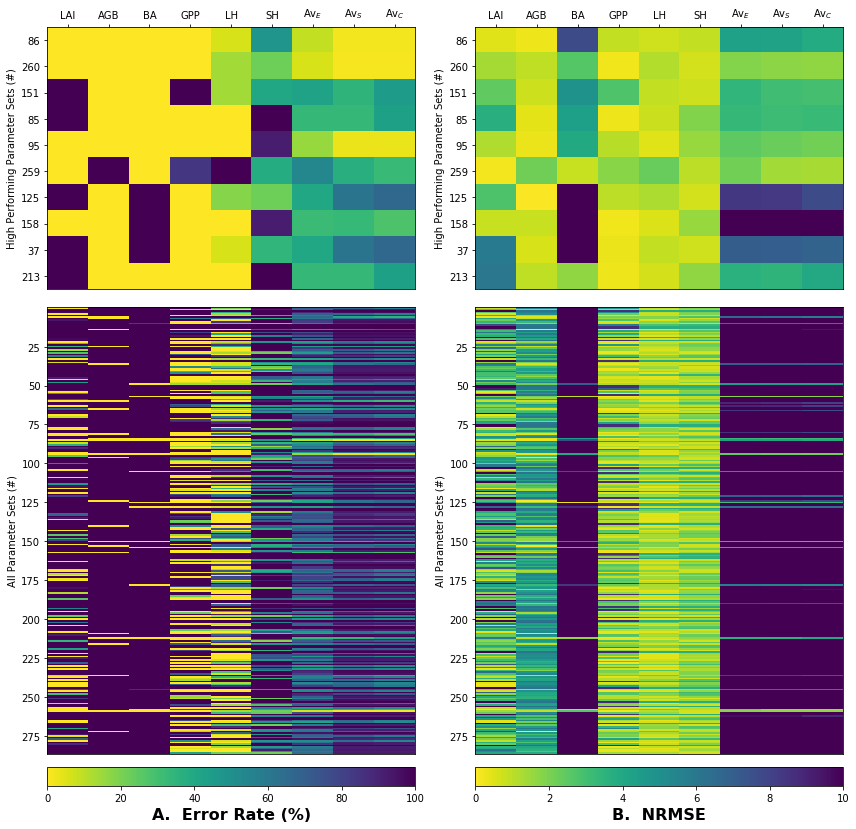

In [56]:
fig1 = plt.figure(figsize=(12,12))

# Set CO2levels index number
casenum = 0

# Plot Error Rate
plotnum = 1
heatsubplotfxn(error_heatdata, casenum, 0, 100, plotnum, 'A.  Error Rate (%)', 
               highperform_indx, heat_var_labels, ens10, enslist)

# Plot NRMSE
plotnum = plotnum+1
heatsubplotfxn(nrmse_heatdata, casenum, 0, 10, plotnum, 'B.  NRMSE', 
               highperform_indx, heat_var_labels, ens10, enslist)

plt.tight_layout()

#### Plot performance metrics for simulations run at 400 ppm carbon dioxide

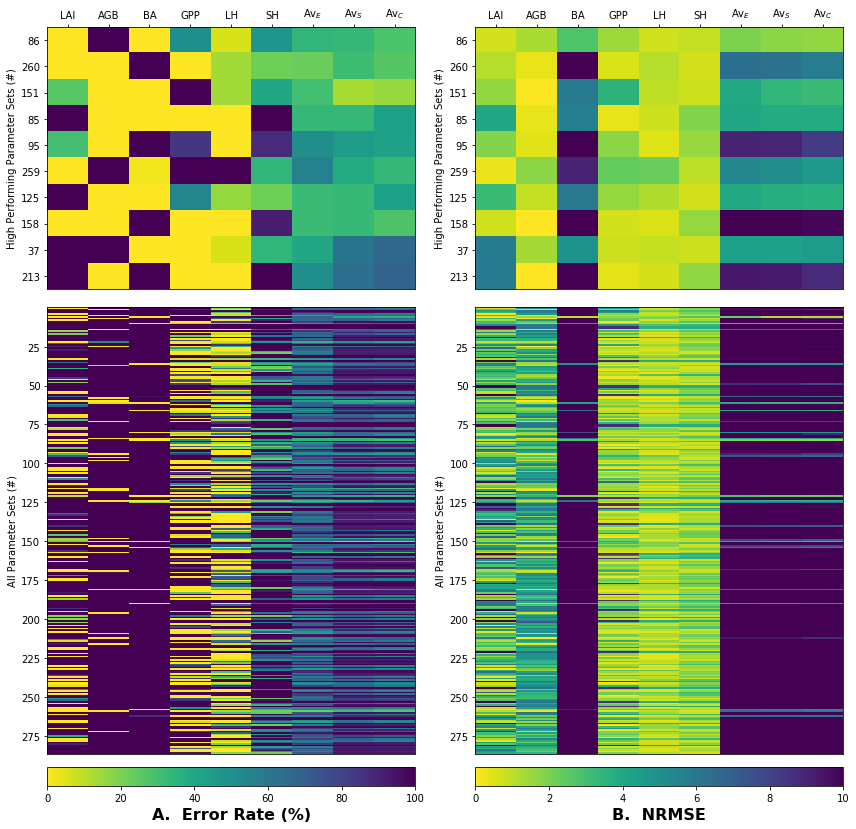

In [58]:
fig2 = plt.figure(figsize=(12,12))

# Set CO2levels index number
casenum = 1

# Plot Error Rate
plotnum = 1
heatsubplotfxn(error_heatdata, casenum, 0, 100, plotnum, 'A.  Error Rate (%)',
              highperform_indx, heat_var_labels, ens10, enslist)

# Plot NRMSE
plotnum = plotnum+1
heatsubplotfxn(nrmse_heatdata, casenum, 0, 10, plotnum, 'B.  NRMSE',
              highperform_indx, heat_var_labels, ens10, enslist)

plt.tight_layout()